# Statystyka w Analizie Danych - Projekt 1 Zadanie 2

+ Autorzy:
    + Łukasz Staniszewski (nr indeksu: 304098)
    + Maksim Makaranka (nr indeksu: 308826)
+ Semestr: 2023Z

## 1. Załadowanie danych, funkcje pomocnicze

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from scipy.stats import expon


from typing import Optional

In [46]:
# FILENAME = "data/gamma/signal_50MHz.bin"
FILENAME = "/Users/lukaszstaniszewski/Documents/study/SAD/project/SAD-unemployment-rate-report/data/gamma/signal_50MHz.bin"
FREQ = 50000000 # 50Mhz

In [47]:
def read_data(filename: str) -> np.ndarray:
    """Reads data from file pointed by filename and returns it as numpy array."""
    data = np.fromfile(filename, dtype=np.float32)
    return data

In [48]:
def plot_data(data: np.ndarray, slice: Optional[slice] = None, title: Optional[str] = None, n_samples_line: Optional[int] = None):
    """Plots signal data.
        param slice: defines slice of data to plot
        param title: if specified, adds title to plot
        param n_samples_line: if specified, draws vertical line at this index"""

    plt.figure(figsize=(10, 4))
    start_idx = 0
    if slice is not None:
        start_idx = slice.start
        data = data[slice]

    plt.plot(np.arange(start_idx, start_idx + len(data)), data)
    if n_samples_line is not None:
        plt.axvline(start_idx + n_samples_line, color='g', linestyle='--')
        plt.text(start_idx + n_samples_line+1, max(data) - 0.01, f"{n_samples_line} próbek po \nwystąpieniu \nimpulsu", color='g')

    if title is not None:
        plt.title(title)
    plt.xticks(ticks=plt.xticks()[0], labels=[f"{x/FREQ:.4f}" for x in plt.xticks()[0]])
    plt.xlabel("czas [s]")
    plt.ylabel("amplituda")
    plt.xlim(start_idx, start_idx + len(data))

    plt.show()


##  2. Analiza impulsów

W celu ustalenia wyglądu impulsów występujących w sygnale i wyznaczenia progu, jaki amplituda danej próbki musi przekroczyć, aby uznać ją za część impulsu, zobrazowaliśmy na wykresie pierwsze $700000$ próbek z detektora. Dodatkowo, za istotne uznaliśmy wykreślenie postaci pierwszych czterech pojedynczych impulsów, a także zwizualizowanie dwóch o mniejszej amplitudzie aby sprawdzić, czy wszystkie one są podobne do siebie pod względem długości trwania w czasie.

### 2.1. Pierwsze $700000$ próbek:

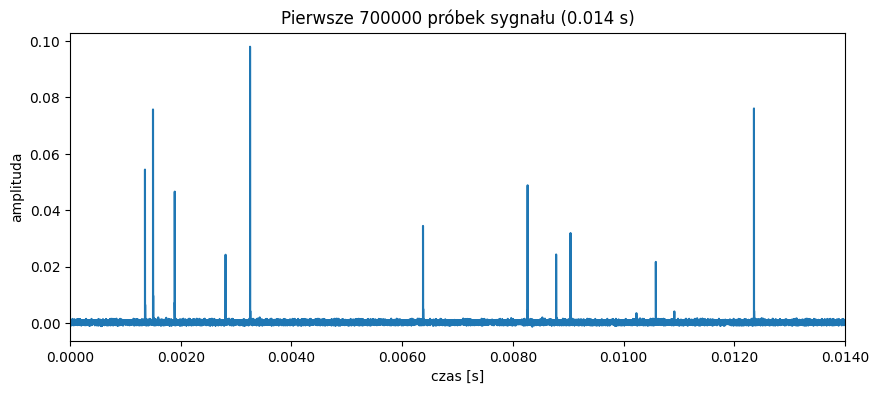

In [49]:
data = read_data(filename=FILENAME)
plot_data(data = data, slice = slice(0,700000), title = f"Pierwsze 700000 próbek sygnału ({700000/FREQ:.3f} s)")

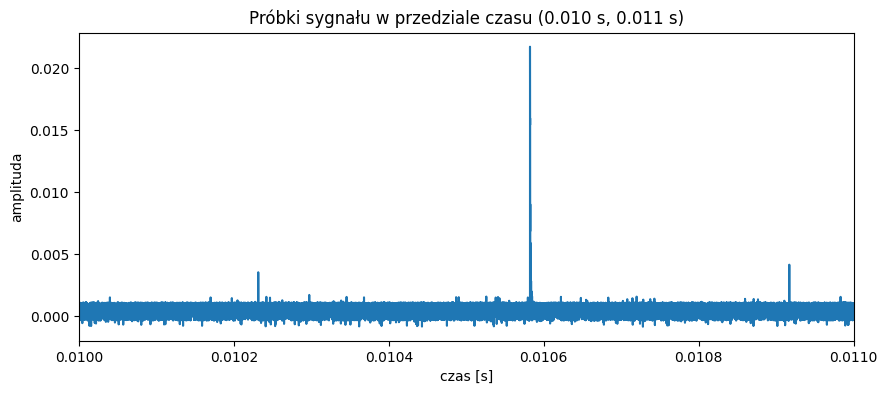

In [50]:
plot_data(data = data, slice = slice(500000,550000), title= f"Próbki sygnału w przedziale czasu ({500000/FREQ:.3f} s, {550000/FREQ:.3f} s)")

### 2.2. Cztery pierwsze impulsy:

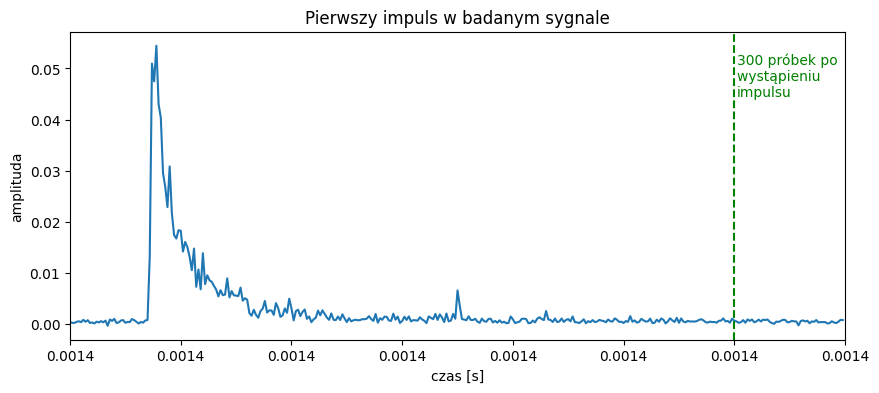

In [51]:
plot_data(data=data, slice=slice(67650, 68000), title=f"Pierwszy impuls w badanym sygnale", n_samples_line=300)

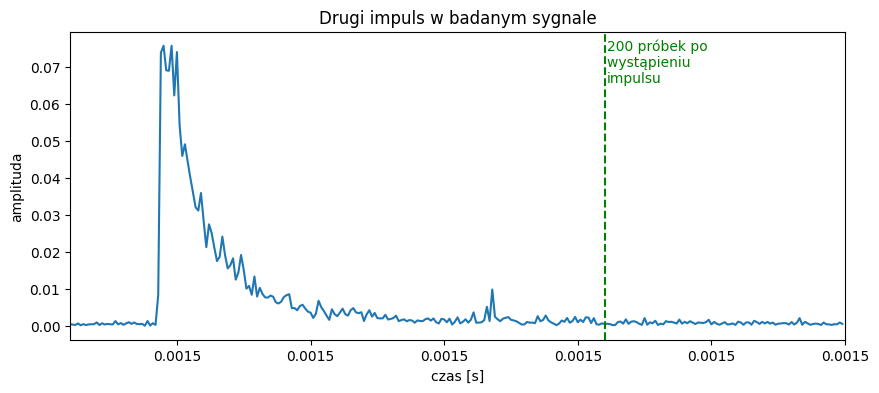

In [52]:
plot_data(data, slice(74910, 75200), title=f"Drugi impuls w badanym sygnale", n_samples_line=200)

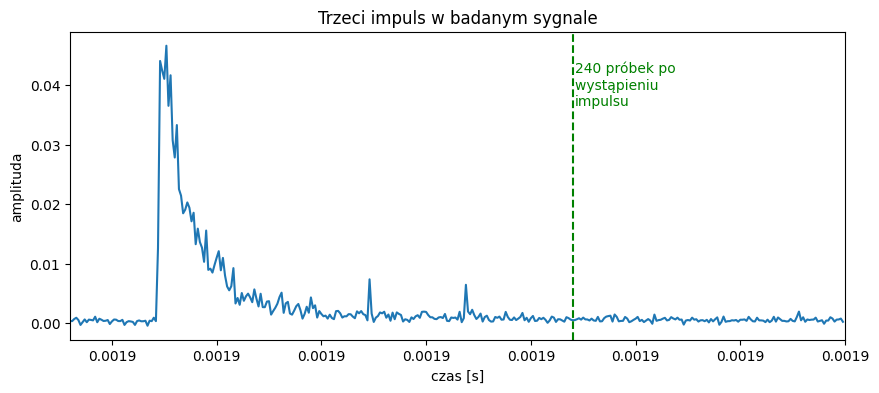

In [53]:
plot_data(data, slice(94530, 94900), title=f"Trzeci impuls w badanym sygnale", n_samples_line=240)


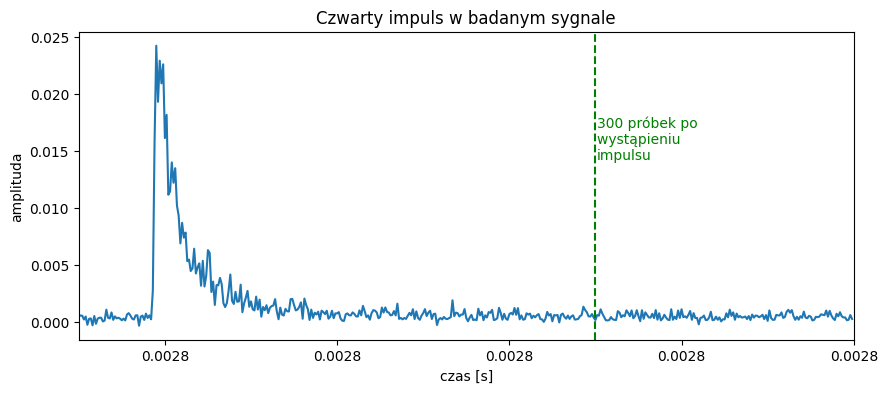

In [54]:
plot_data(data, slice(140450, 140900), title=f"Czwarty impuls w badanym sygnale", n_samples_line=300)

### 2.3. Wnioski
+ Bazując na powyższych wykresach, możemy stwierdzić, że impulsy mogą być wykrywalne, gdy amplituda sygnału przekracza wartość $0.0025$.
+ Zauważono, że impulsy wyglądają zasadniczo podobnie i na maksymalnie ok. $300$ próbek po wystąpieniu anomalii, sygnał wraca do stanu normalnego. 


## 3. Analiza sygnału bez impulsów

### 3.1. Metody filtracji
- Filtracja z progiem - odrzucenie próbek, których wartość wychodzi poza standardowy zakres, w przypadku tego projektu za standardowy zakres wartości amplitudy uznano $<-0.0005,0.0025>$.
- Filtracja z oknem - znalezienie okien czasu, w których wartość wyszła poza standardowy zakres i usunięcie określonej liczby próbek w przód i w tył od danego momentu w czasie. W przypadku tego projektu, za próbki niestandardowe uznano te, których wartość przekracza próg $0.0025$ i względem nich usuwano odpowiednio: $100$ próbek w tył i $300$ próbek w przód.

In [55]:
def filter_window(data: np.ndarray, threshold: float, window_before: int, window_after: int) -> np.ndarray:
    """Performs signal filtering by removing samples in that exceed threshold along with the neighbouring samples (window_before to the left and window_after to the right)."""
    exceed_indices = np.where(np.abs(data) > threshold)[0]
    starts = np.maximum(exceed_indices - window_before, 0)
    ends = np.minimum(exceed_indices + window_after, len(data))
    mask = np.ones(len(data), dtype=bool)

    for start, end in zip(starts, ends):
        mask[start:end] = False
    return data[mask]

In [56]:
def filter_threshold(data: np.ndarray, threshold_start: int, threshold_end: int) -> np.ndarray:
    """Performs signal filtering by removing samples that are outside of the threshold range."""
    return data[(threshold_start < data) & (data < threshold_end)]


In [57]:
data_filtered_threshold = filter_threshold(data, threshold_start=-0.0005, threshold_end=0.0025)

In [58]:
data_filtered_wind = filter_window(data, threshold=0.0025, window_before=100, window_after=300)

+ Wykres po filtracji z progiem:

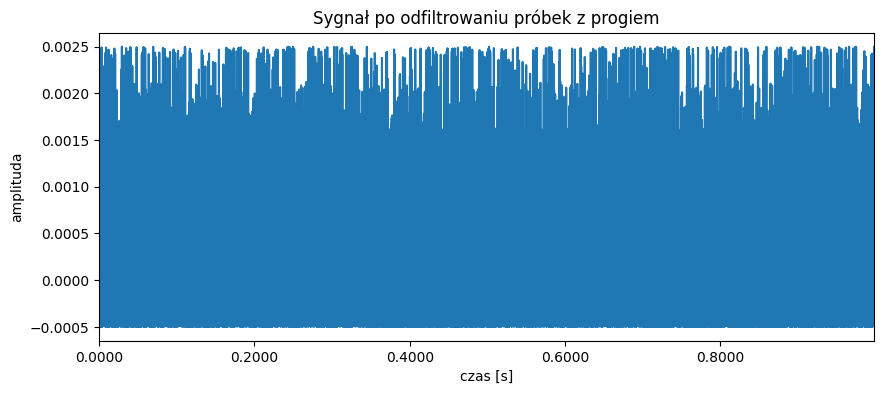

In [59]:
plot_data(data_filtered_threshold, title="Sygnał po odfiltrowaniu próbek z progiem")

+ Wykres po filtracji z oknem:

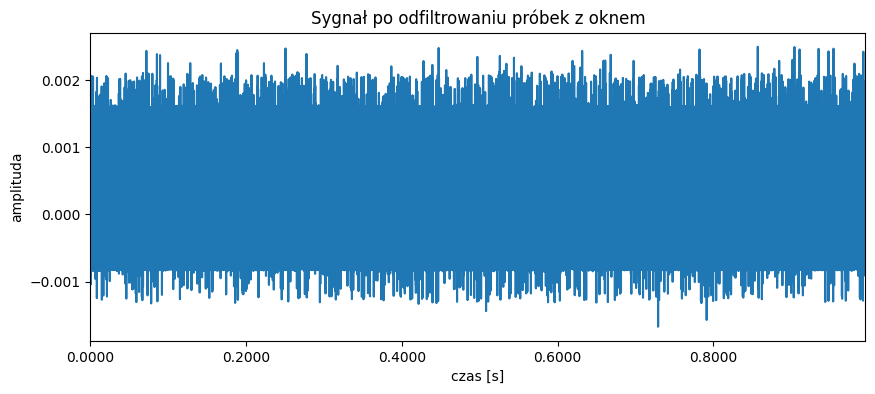

In [60]:
plot_data(data_filtered_wind, title="Sygnał po odfiltrowaniu próbek z oknem")

### 3.2. Rozkład wartości sygnału po filtracji

In [61]:
def plot_dist(data: np.ndarray, bins: int, plt_title: Optional[str] = None):
    """Plots distribution of provided data. Uses histogram, with specified number of bins.
    params plt_tile: if specified, adds title to plot
    """
    plt.figure(figsize=(8, 4))
    plt.hist(data, bins=bins, alpha=0.75, color='orange', edgecolor='none', density=True)

    median_val = np.median(data)
    plt.axvline(median_val, color='r', linestyle='--', linewidth=1.5, label='Mediana')
    plt.legend()

    plt.xlim(np.min(data), np.max(data))

    if plt_title:
        plt.title(plt_title)
    plt.xlabel("Amplituda")
    plt.ylabel("Częstość występowania")
    plt.show()

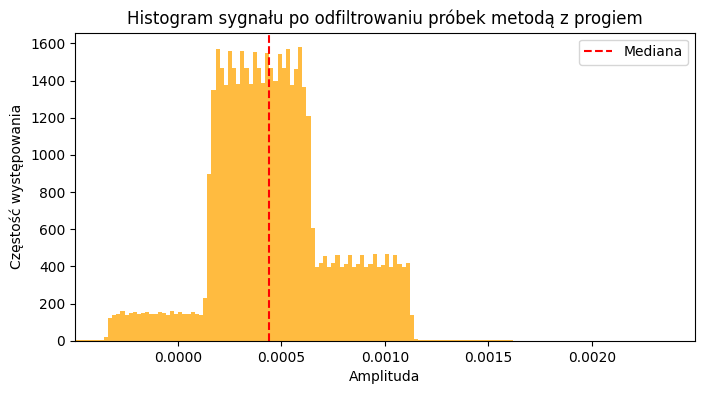

In [62]:
plot_dist(data_filtered_threshold, bins=150, plt_title="Histogram sygnału po odfiltrowaniu próbek metodą z progiem")

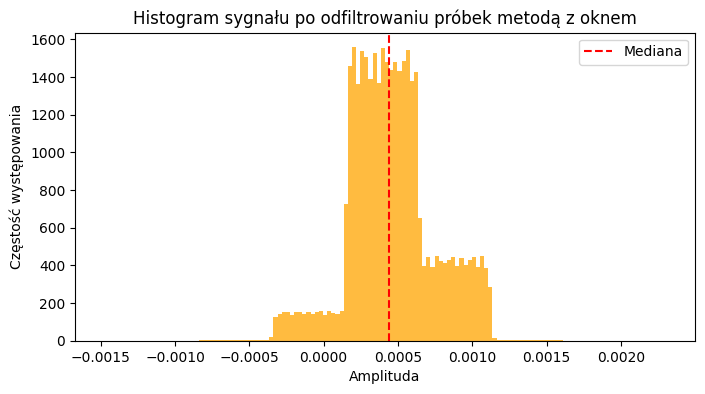

In [63]:
plot_dist(data_filtered_wind, bins=150, plt_title="Histogram sygnału po odfiltrowaniu próbek metodą z oknem")

### 3.3. Dodatkowy eksperyment: stacjonarność sygnału
Zbadaliśmy stacjonarność przefiltrowanego sygnału, tzn. podzieliliśmy cały sygnał na 8 części o równym czasie i sprawdziliśmy czy jego rozkład wygląda (prawie) tak samo na początku (w pierwszej części sygnału), w środku (w piątej części) i na końcu (w ostatniej części) badanego fragmentu. 

In [64]:
data_slice = data_filtered_threshold.shape[0] // 8

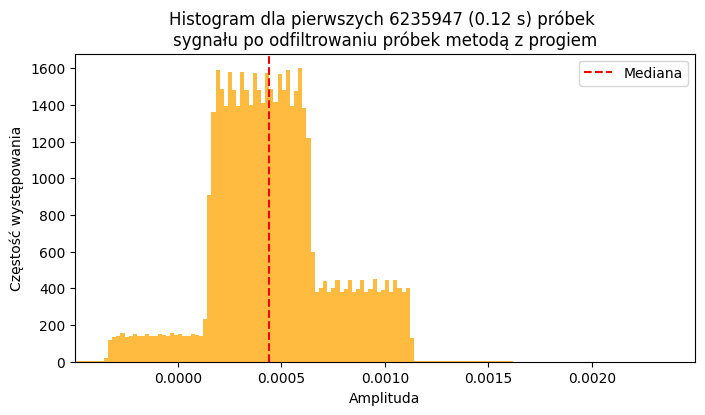

In [65]:
plot_dist(data_filtered_threshold[:data_slice], bins=150, plt_title=f"Histogram dla pierwszych {data_slice} ({data_slice/FREQ:.2f} s) próbek \nsygnału po odfiltrowaniu próbek metodą z progiem")

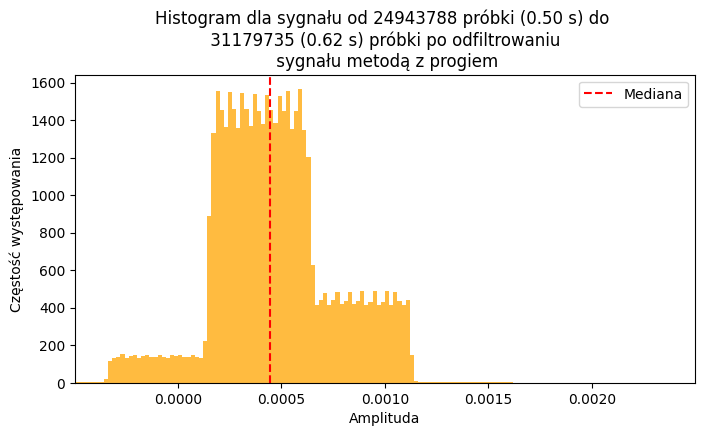

In [66]:
plot_dist(data_filtered_threshold[data_slice*4:data_slice*5], bins=150, plt_title=f"Histogram dla sygnału od {data_slice*4} próbki ({data_slice*4/FREQ:.2f} s) do \n {data_slice*5} ({data_slice*5/FREQ:.2f} s) próbki po odfiltrowaniu \n sygnału metodą z progiem")

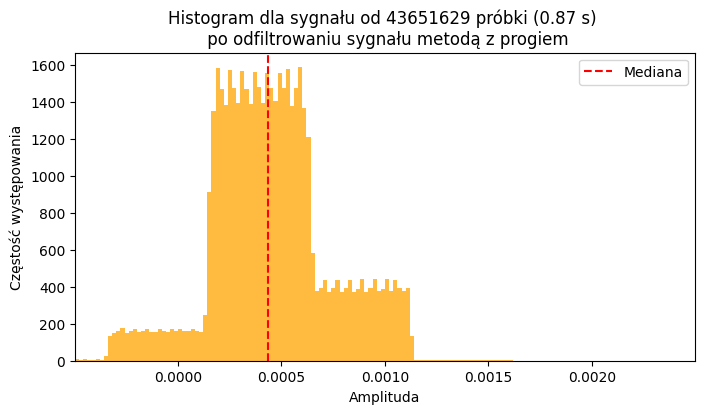

In [67]:
plot_dist(data_filtered_threshold[data_slice*7:], bins=150, plt_title=f"Histogram dla sygnału od {data_slice*7} próbki ({data_slice*7/FREQ:.2f} s) \n po odfiltrowaniu sygnału metodą z progiem")

### 3.4. Dodatkowy eksperyment: ile próbek potrzeba, aby móc zaaproksymować sygnał?
Wybierając coraz to liczniejsze (w próbki) początkowe fragmenty sygnału, sprawdziliśmy, jaka ich liczba jest potrzebna, aby otrzymać rozkład podobny do rozkładu sygnału na pełnym przedziale czasowym.

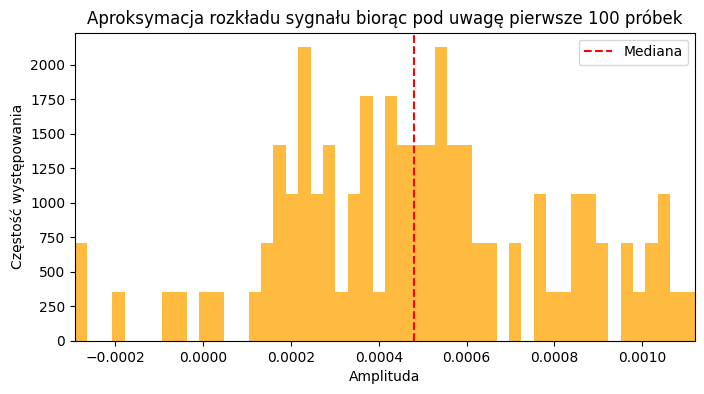

In [73]:
plot_dist(data_filtered_threshold[:100], bins=50, plt_title=f"Aproksymacja rozkładu sygnału biorąc pod uwagę pierwsze 100 próbek")

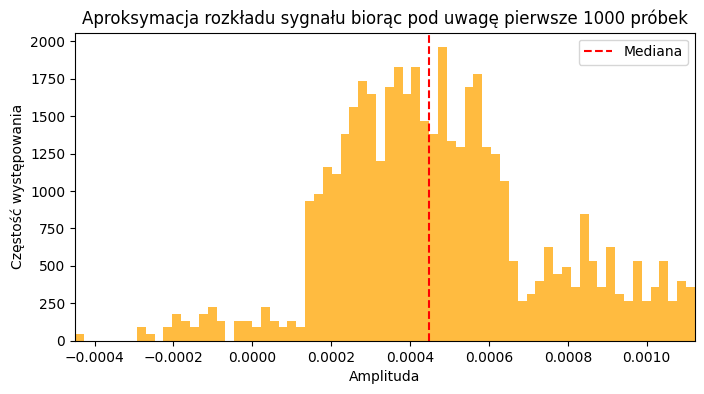

In [74]:
plot_dist(data_filtered_threshold[:1000], bins=70, plt_title=f"Aproksymacja rozkładu sygnału biorąc pod uwagę pierwsze 1000 próbek")

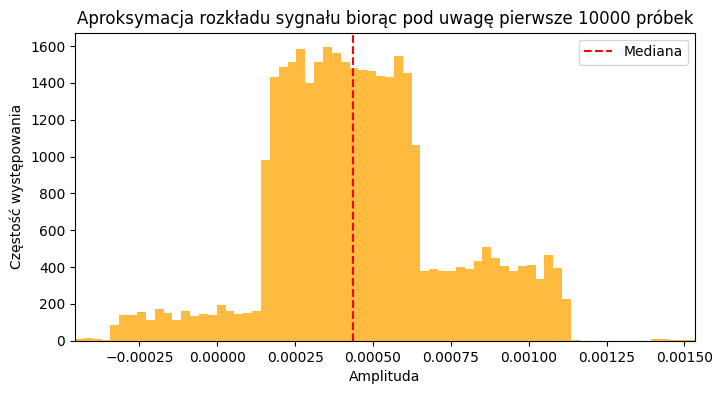

In [75]:
plot_dist(data_filtered_threshold[:10000], bins=70, plt_title=f"Aproksymacja rozkładu sygnału biorąc pod uwagę pierwsze 10000 próbek")

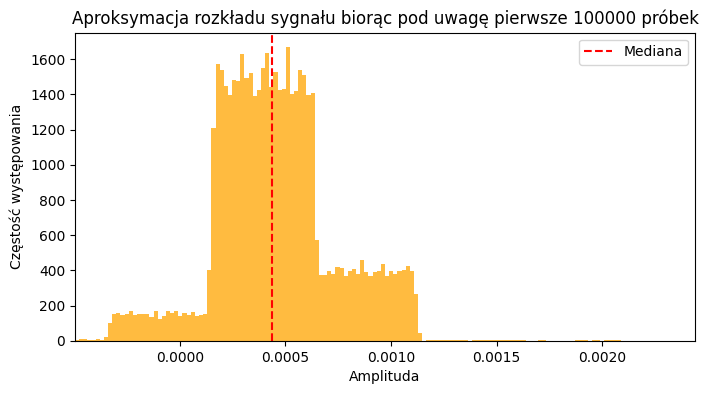

In [76]:
plot_dist(data_filtered_threshold[:100000], bins=150, plt_title=f"Aproksymacja rozkładu sygnału biorąc pod uwagę pierwsze 100000 próbek")

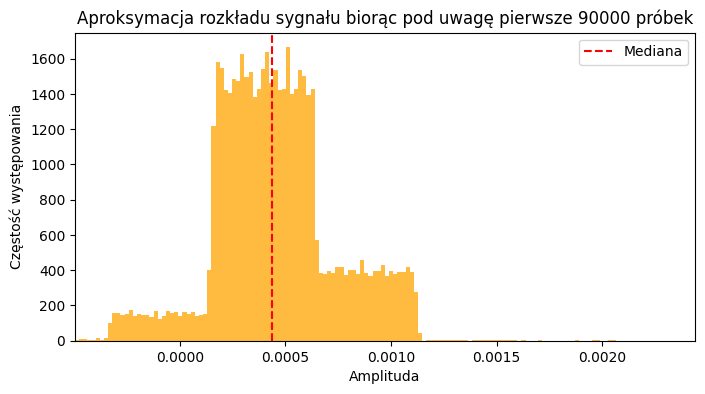

In [77]:
plot_dist(data_filtered_threshold[:90000], bins=150, plt_title=f"Aproksymacja rozkładu sygnału biorąc pod uwagę pierwsze 90000 próbek")

### 3.5. Dodatkowy eksperyment: wykres pudełkowy sygnału a filtracja
Postanowiliśmy również sprawdzić, jak wpływa zastosowanie filtracji na wykres pudełkowy sygnału. W tym celu wykreśliliśmy taki wykres zarówno dla sygnału przed filtracją, jak i po filtracji z progiem oraz po filtracji z oknem.
Wąsy wyznaczane były standardowo, z następujących wzorów:
- Rozstęp międzykwartylowy: $IQR=Q_3-Q_1$
- Dolny wąs: $x_*=Q_1-1.5 \cdot IQR$
- Górny wąs: $x^*=Q_3+1.5 \cdot IQR$

In [78]:
def plot_boxplot(data: np.ndarray, plt_title: Optional[str] = None):
    """Plots boxplot of provided data, adds info about median, q1, q3, iqr, whiskers to the plot.
    param plt_title: if specified, adds title to plot
    """
    median = np.median(data)
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_whisker = q1 - 1.5 * iqr
    upper_whisker = q3 + 1.5 * iqr

    plt.figure(figsize=(6,7))
    plt.boxplot(data)

    plt.text(1.1, median, f'Mediana: {median:.4f}', verticalalignment='center')
    plt.text(1.1, q1, f'Q1: {q1:.4f}', verticalalignment='center')
    plt.text(1.1, q3, f'Q3: {q3:.4f}', verticalalignment='center')
    plt.text(1.1, lower_whisker, f'Dolny wąs: {lower_whisker:.4f}', verticalalignment='center')
    plt.text(1.1, upper_whisker, f'Górny wąs: {upper_whisker:.4f}', verticalalignment='center')

    if plt_title:
        plt.title(plt_title)
    plt.ylabel("Amplituda")
    plt.xticks([])
    plt.show()




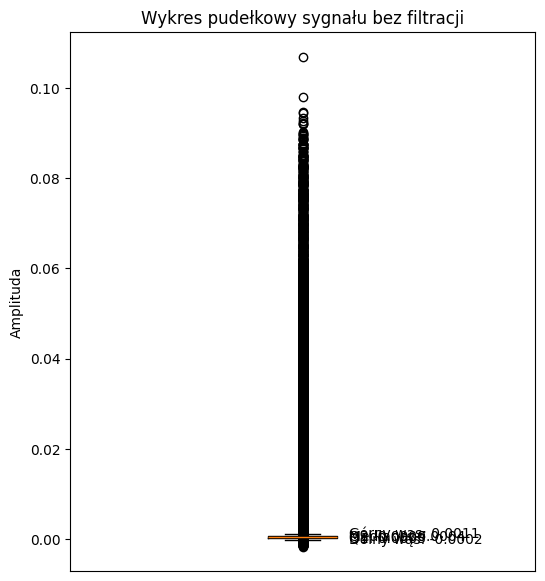

In [79]:
plot_boxplot(data, plt_title="Wykres pudełkowy sygnału bez filtracji")

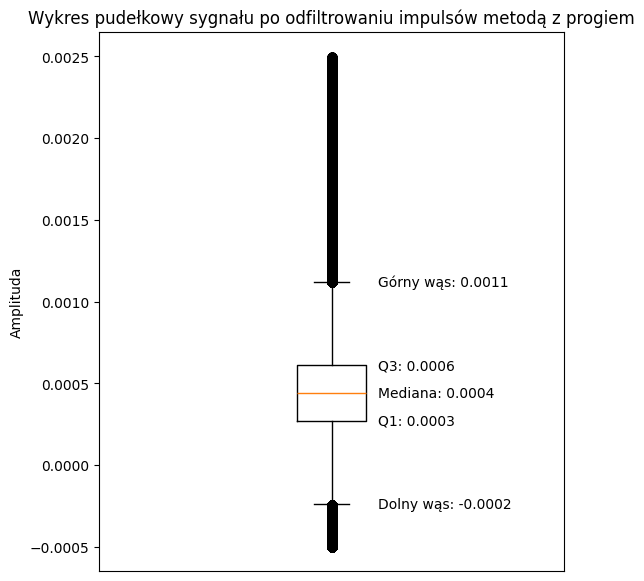

In [80]:
plot_boxplot(data_filtered_threshold, plt_title="Wykres pudełkowy sygnału po odfiltrowaniu impulsów metodą z progiem")

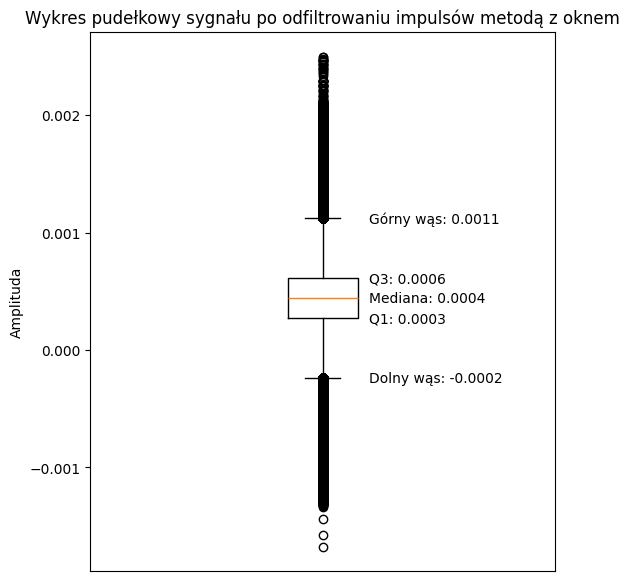

In [81]:
plot_boxplot(data_filtered_wind, plt_title="Wykres pudełkowy sygnału po odfiltrowaniu impulsów metodą z oknem")

### 3.6. Wnioski
+ Można zauważyć, że, pomimo zastosowania przez nas dwóch różnych metod filtracji, wyjściowe rozkłady wartości sygnału posiadały ten sam kształt.
+ Na rozkładzie amplitudy sygnału można zauważyć trzy wyróżniające się fragmenty - "progi" - odpowiednio dla przedziałów $(-0.0003, 0.0001)$, $(0.0002, 0.0007)$ oraz $(0.0008, 0.0011)$. Są to przedziały, w których częstości występowania próbek są bardzo zbliżone do siebie. W rozkładzie występuje wysoki, dobrze widoczny, szczyt, dla przedziału $(0.0002, 0.0007)$. Takie wartości amplitudy najczęściej występują w opisywanym sygnale, co wskazuje wysoką koncetrację wartości sygnału w tych okolicach.
+ Wartości dodatnie sygnału wyglądają na zdecydowanie bardziej dominujące w liczności nad wartościami ujemnymi, co oznacza, że dodatnie wartości amplitudy przeważają w sygnale. Mediana amplitudy sygnału jest również dodatnia, co wskazuje przeważający "dodatni" charakter próbek w sygnale. 
+ W pobliżu wartości szczytowych, zauważalne są zniekształcenia lub nieregularności, występujące okresowo, które mogą być dodatkowym szumem pochodzącym z niedoskonałości samego detektora. 
+ Badany sygnał jest stacjonarny, co oznacza, że jego rozkład wartości amplitudy nie zmienia się w czasie i jest bardzo podobny na początku badania, w środku, jak i na samym końcu.
+ Aby móc odpowiednio zaaproksymować rozkład sygnału na całym przedziale czasowym, konieczne jest posiadanie ok. $90000$ próbek, co oznacza, przy częstotliwości próbkowania wynoszącej $50$ MHz, że trzeba obserwować sygnał przez conajmniej $0.0018$ sekundy.
+ Próba wykreślenia wykresu pudełkowego dla początkowego sygnału (przed usuwaniem impulsów) jest problematyczna - występuje zbyt wiele próbek odstających, w tym niektóre na tyle oddalone od "wąsów" wykresu, że zauważenie samego pudełka na obrazie wynikowym jest niewykonalne. Na wykresach pudełkowych wykreślonych po zastosowaniu filtrowania sygnału dla obu podejść, możliwe jest już zauważenie mediany, kwartylów, a także wąsów wykresu. W przypadku tych dwóch wykresów, wciąż można zauważyć próbki odstające, natomiast zastosowanie progu w obu metodach filtrowania, eliminuje najbardziej oddalone od "centrum" próbki, dzięki czemu wykres pudełkowy jest bardziej czytelny i można na nim zauważyć medianę czy kwartyle.

## 4. Analiza występowania impulsów

### 4.1. Rozkład odstępu czasu pomiędzy kolejnymi impulsami
Nasza metoda do wykrywania kolejnych impulsów polega na:
1. wykrywanie anomalii - stworzeniu maski sygnału, gdzie wartość $1$ dla $i$-tej próbki oznacza, że wartość jej amplitudy jest większa od ustalonego progu, a $0$ - gdy taka sytuacja nie ma miejsca;
2. grupowanie w pojedyncze impulsy - idąc od początku sygnału do końca, w czasie, znajdujemy kolejne próbki o masce $1$ i zerujemy te fragmenty tej maski, które występują na $n$ próbek za danym impulsem, przez co eliminujemy sytuację, gdy istnieje dwukrotnie $1$ w masce dla tego samego impulsu.

In [82]:
def get_single_peaks(data: np.ndarray, threshold: float, window_size_before: int, window_size_after: int) -> np.ndarray:
    """Returns mask of booleans indicating where, in input data, the peaks occur.
    param threshold: threshold value for peak detection
    param window_size_before: number of samples before peak to be zeroed
    param window_size_after: number of samples after peak to be zeroed
    """
    impulse_thresholded = data > threshold
    impulse_occurrences_windowed = deepcopy(impulse_thresholded)

    for index in np.where(impulse_thresholded)[0]:
        if impulse_occurrences_windowed[index]:
            start_index = max(index - window_size_before, 0)
            end_index = min(index + window_size_after, len(data))
            impulse_occurrences_windowed[start_index:end_index] = 0
            impulse_occurrences_windowed[index] = True

    return impulse_occurrences_windowed

def get_next_peak_distances(peaks: np.ndarray) -> np.ndarray:
    """Returns calculated distances (in number of samples) between peaks."""
    indices = np.where(peaks == 1)[0]
    distances = np.diff(indices)
    return distances

In [83]:
def plot_exp_hist(data: np.ndarray, bins: int, plt_title: Optional[str] = None, est_exp: Optional[bool] = True):
    """Plots a distribution of provided data, along with approximated exponential distribution fitted to it.
    param bins: number of bins for histogram
    param plt_title: if specified, adds title to plot
    param est_exp: if True, estimates exponential distribution parameters and plots it
    """
    plt.figure(figsize=(10, 5))

    # distribution
    plt.hist(data, bins=bins, alpha=0.25, color='blue', edgecolor='none', density=est_exp)
    plt.xticks(ticks=plt.xticks()[0], labels=[f"{x/FREQ:.4f}" for x in plt.xticks()[0]])

    # approx dist
    if est_exp:
        loc, lambd = expon.fit(data)
        xmin, xmax = plt.xlim()
        x = np.linspace(xmin, xmax, 100)
        pdf = expon.pdf(x, loc=loc, scale=lambd)
        plt.plot(x, pdf, linewidth=4, label="Aproksymacja rozkładu wykładniczego (lambda={:.4f})".format(lambd), c="orange")
        ylabel = "Częstość występowania (znormalizowana do 1)"
    else:
        ylabel = "Częstość występowania"

    # plot settings
    if plt_title is not None:
        plt.title(plt_title)
    plt.xlabel('Dystans w czasie pomiędzy kolejnymi impulsami [s]')
    plt.ylabel(f"{ylabel}")
    plt.xlim((0, None))
    plt.legend()
    plt.show()

In [84]:
data = read_data(filename=FILENAME)

Użyliśmy nieco mniejszego progu tutaj do wykrywania impulsów niż ten w poprzednim punkcie ($0.0015$ zamiast $0.0025$), ponieważ tak otrzymujemy nieco więcej dystansów pomiędzy kolejnymi impulsami i aproksymacja jest dokładniejsza. Ostatecznie otrzymujemy histogram odstępów czasu pomiędzy kolejnymi impulsami.

In [85]:
impulse_occurrences_windowed = get_single_peaks(data=data, threshold=0.0015, window_size_before=0, window_size_after=500)
next_peak_distances = get_next_peak_distances(impulse_occurrences_windowed)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


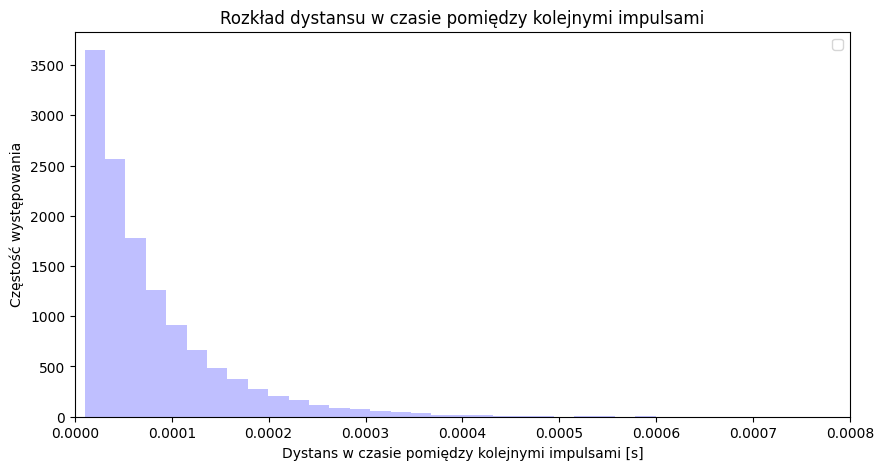

In [86]:
plot_exp_hist(data=next_peak_distances, bins=35, plt_title='Rozkład dystansu w czasie pomiędzy kolejnymi impulsami', est_exp=False)

Uwaga: na kolejnych wykresach zamieszczamy dodatkowo estymację rozkładu wykładniczego na podstawie danych, aby móc porównać, czy rzeczywiście rozkład odstępów czasu pomiędzy kolejnymi impulsami jest wykładniczy. Wymaga to znormalizowania częstości na osi OY, tak by w sumie dawały one $1$. 

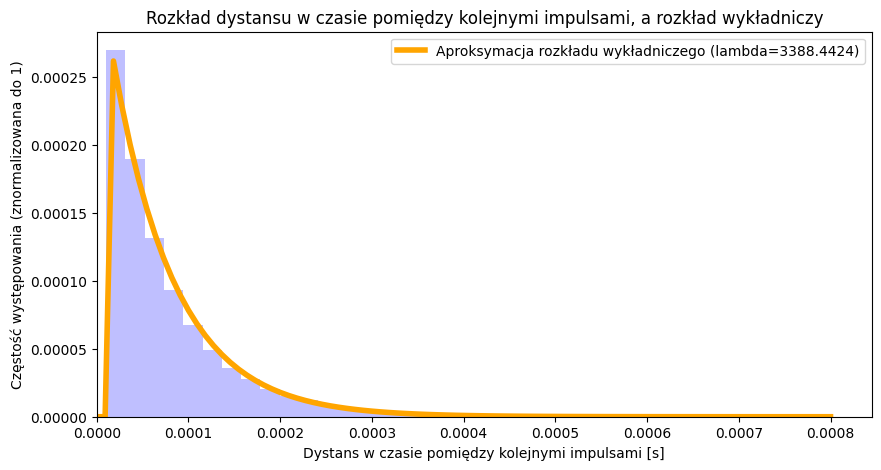

In [87]:
plot_exp_hist(data=next_peak_distances, bins=35, plt_title='Rozkład dystansu w czasie pomiędzy kolejnymi impulsami, a rozkład wykładniczy')

### 4.2. Ile próbek potrzeba do estymacji tego rozkładu?

Posiadane wartości dystansu między kolejnymi impulsami: 19


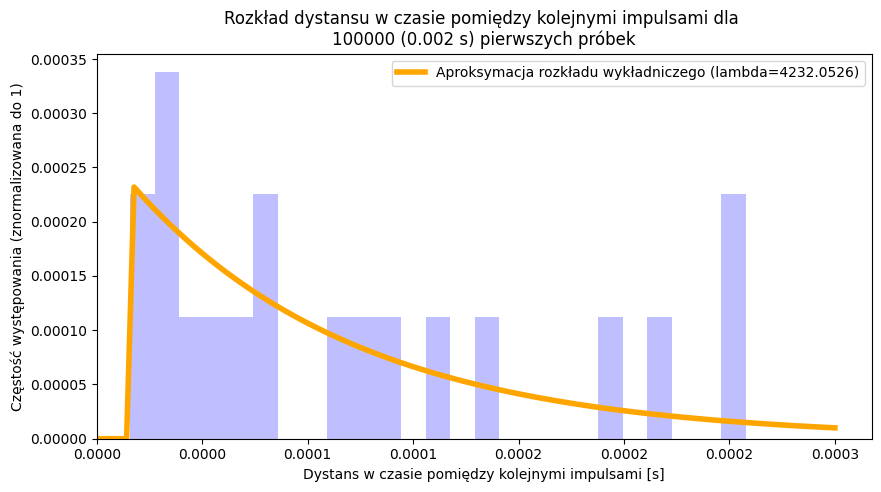

In [88]:
impulse_occurrences_windowed = get_single_peaks(data=data[:100000], threshold=0.0015, window_size_before=0, window_size_after=500)
next_peak_distances = get_next_peak_distances(impulse_occurrences_windowed)
print(f"Posiadane wartości dystansu między kolejnymi impulsami: {len(next_peak_distances)}")
plot_exp_hist(data=next_peak_distances, bins=25, plt_title=f'Rozkład dystansu w czasie pomiędzy kolejnymi impulsami dla \n100000 ({100000/FREQ:.3f} s) pierwszych próbek')

Posiadane wartości dystansu między kolejnymi impulsami: 201


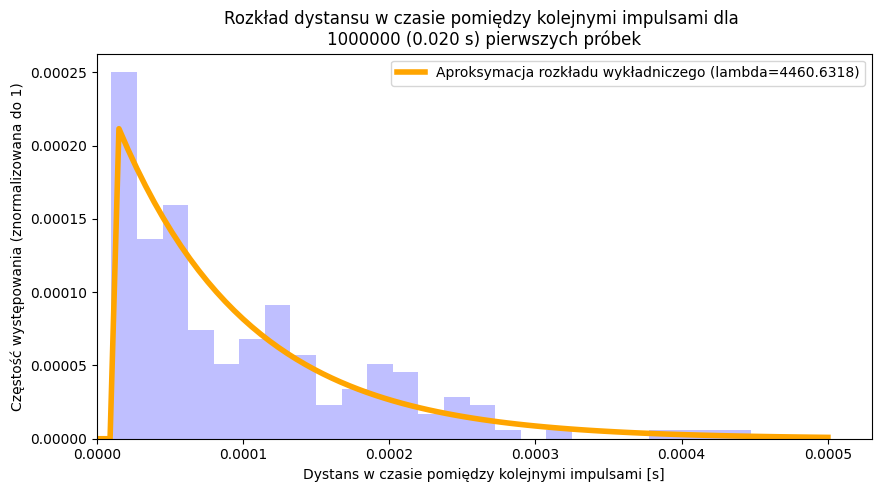

In [89]:
impulse_occurrences_windowed = get_single_peaks(data=data[:1000000], threshold=0.0015, window_size_before=0, window_size_after=500)
next_peak_distances = get_next_peak_distances(impulse_occurrences_windowed)
print(f"Posiadane wartości dystansu między kolejnymi impulsami: {len(next_peak_distances)}")
plot_exp_hist(data=next_peak_distances, bins=25, plt_title=f'Rozkład dystansu w czasie pomiędzy kolejnymi impulsami dla \n1000000 ({1000000/FREQ:.3f} s) pierwszych próbek')

Posiadane wartości dystansu między kolejnymi impulsami: 411


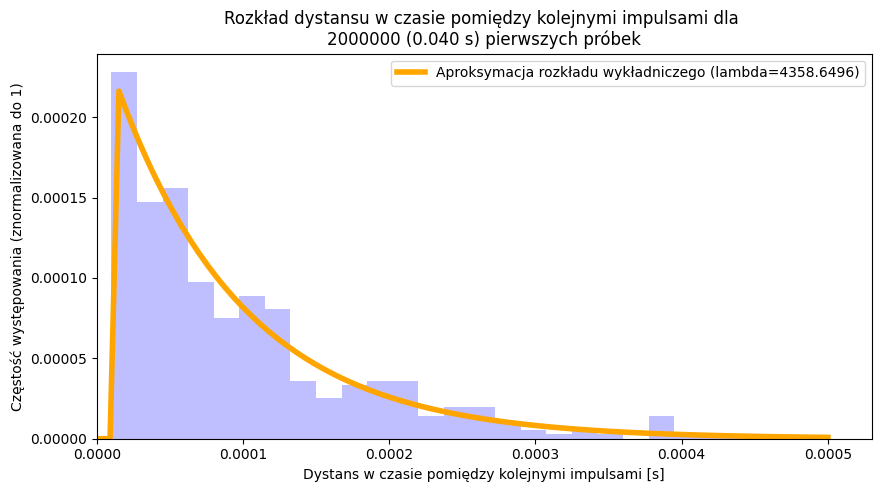

In [90]:
impulse_occurrences_windowed = get_single_peaks(data=data[:2000000], threshold=0.0015, window_size_before=0, window_size_after=500)
next_peak_distances = get_next_peak_distances(impulse_occurrences_windowed)
print(f"Posiadane wartości dystansu między kolejnymi impulsami: {len(next_peak_distances)}")
plot_exp_hist(data=next_peak_distances, bins=25, plt_title=f'Rozkład dystansu w czasie pomiędzy kolejnymi impulsami dla \n2000000 ({2000000/FREQ:.3f} s) pierwszych próbek')


Posiadane wartości dystansu między kolejnymi impulsami: 1132


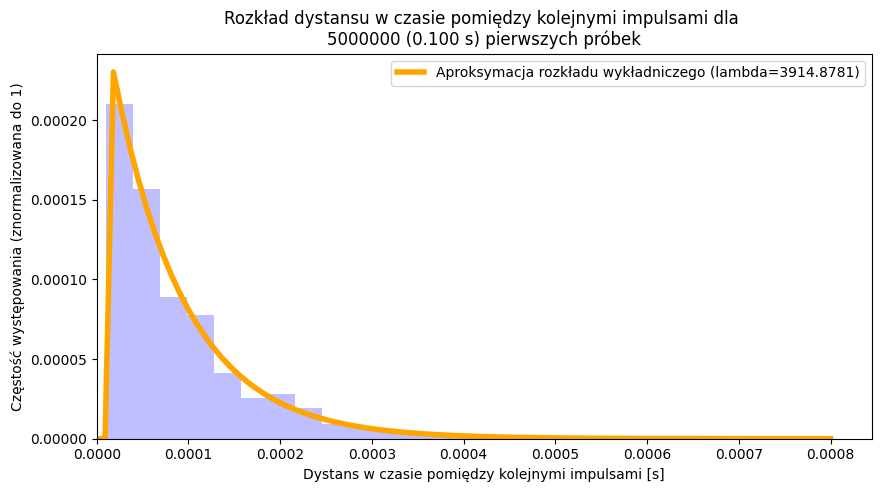

In [91]:
impulse_occurrences_windowed = get_single_peaks(data=data[:5000000], threshold=0.0015, window_size_before=0, window_size_after=500)
next_peak_distances = get_next_peak_distances(impulse_occurrences_windowed)
print(f"Posiadane wartości dystansu między kolejnymi impulsami: {len(next_peak_distances)}")
plot_exp_hist(data=next_peak_distances, bins=25, plt_title=f'Rozkład dystansu w czasie pomiędzy kolejnymi impulsami dla \n5000000 ({5000000/FREQ:.3f} s) pierwszych próbek')

Posiadane wartości dystansu między kolejnymi impulsami: 2186


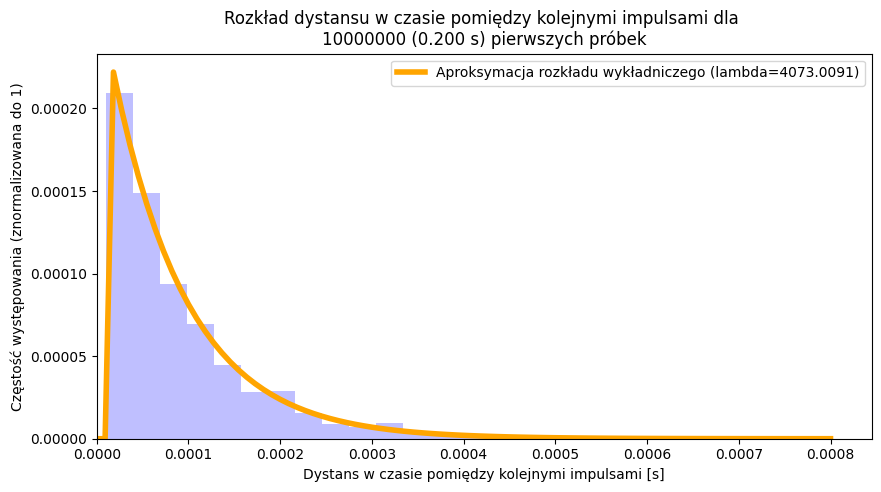

In [92]:
impulse_occurrences_windowed = get_single_peaks(data=data[:10000000], threshold=0.0015, window_size_before=0, window_size_after=500)
next_peak_distances = get_next_peak_distances(impulse_occurrences_windowed)
print(f"Posiadane wartości dystansu między kolejnymi impulsami: {len(next_peak_distances)}")
plot_exp_hist(data=next_peak_distances, bins=25, plt_title=f'Rozkład dystansu w czasie pomiędzy kolejnymi impulsami dla \n10000000 ({10000000/FREQ:.3f} s) pierwszych próbek')

Posiadane wartości dystansu między kolejnymi impulsami: 7620


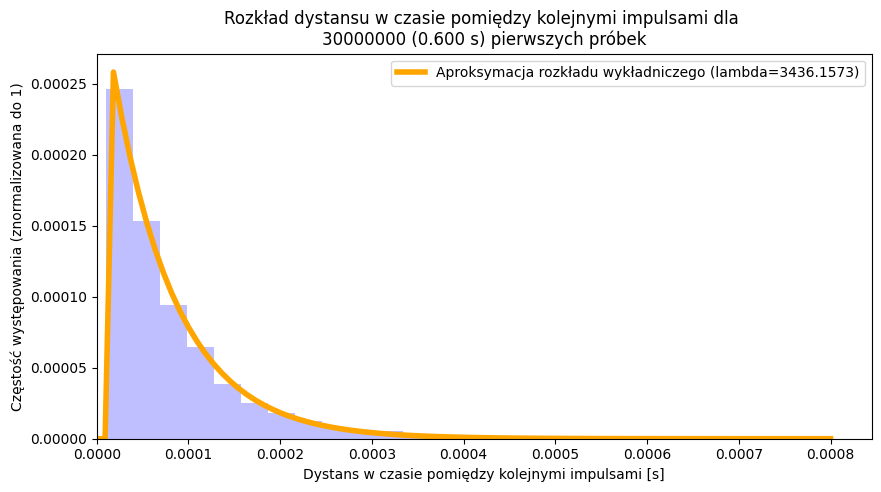

In [93]:
impulse_occurrences_windowed = get_single_peaks(data=data[:30000000], threshold=0.0015, window_size_before=0, window_size_after=500)
next_peak_distances = get_next_peak_distances(impulse_occurrences_windowed)
print(f"Posiadane wartości dystansu między kolejnymi impulsami: {len(next_peak_distances)}")
 plot_exp_hist(data=next_peak_distances, bins=25, plt_title=f'Rozkład dystansu w czasie pomiędzy kolejnymi impulsami dla \n30000000 ({30000000/FREQ:.3f} s) pierwszych próbek')

# Wnioski:
- Badając wyznaczony histogram odstępów czasu pomiędzy kolejnymi impulsami w sygnale, można zauważyć, że przypomina on rozkład wykładniczy, który określa się jako rozkład zmiennej losowej opisującej czas oczekiwania na zjawisko całkowicie losowe, mogące zajść w dowolnej chwili (jakim, w przypadku tego eskperymentu, jest pojawienie się nagłego, nieregularnego impulsu w sygnale). Postanowiliśmy aproksymować rozkład wykładniczy dla całego sygnału, skutkiem czego otrzymaliśmy taki rozkład o wartości parametru $\lambda=3388$.
- Aby móc poprawnie zaaproksymować rozkład wizualnie, wystarczające jest posiadanie $5000000$ próbek (obserwowanie sygnału przez $0.1$ sekundy) - mamy wtedy dostęp do $1132$ dystansów pomiędzy kolejnymi impulsami. Jeśli jednak chcemy aproksymować rozkład wykładniczy dokładniej, to taki rozkład, o przybliżonej wartości współczynnika $\lambda$, udało się wyznaczyć dopiero po $30000000$ próbkach (po $0.6$ sekundy), kiedy mamy dostęp do $7620$ wartości dystansu w czasie. 
